In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

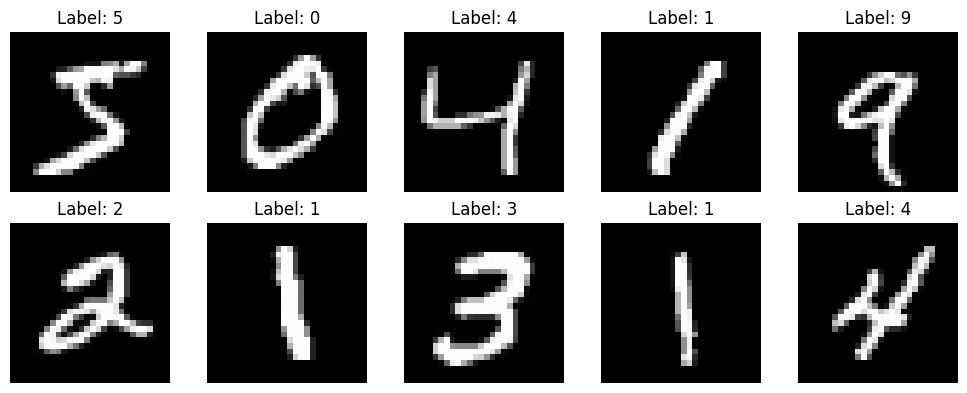

In [3]:
# Visualize some data
def visualize_data(x_data, y_data):
    plt.figure(figsize=(10, 4))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_data[i], cmap='gray')
        plt.title(f"Label: {y_data[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_data(x_train, y_train)

In [4]:
# Preprocess the data
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Normalize the images
x_train = x_train / 255.0
x_test = x_test / 255.0

# Convert labels to categorical
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Resize the images to match VGG input size (48x48, 3 channels)
from tensorflow.image import resize
x_train = resize(x_train, (48, 48))
x_test = resize(x_test, (48, 48))
x_train = np.repeat(x_train, 3, axis=-1)
x_test = np.repeat(x_test, 3, axis=-1)

In [5]:
# Load the VGG16 model
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze the base model layers
for layer in vgg_base.layers:
    layer.trainable = False

In [6]:
# Build the model
model = Sequential([
    vgg_base,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

subset_size = 5000  # Reduce dataset size for quicker training
x_train_subset = x_train[:subset_size]
y_train_subset = y_train[:subset_size]

# Train the model
history = model.fit(x_train_subset, y_train_subset, epochs=5, batch_size=256, validation_data=(x_test, y_test))

Epoch 1/5
20/20 [==============================] - 82s 4s/step - loss: 2.0720 - accuracy: 0.2788 - val_loss: 1.6260 - val_accuracy: 0.6000
Epoch 2/5
20/20 [==============================] - 78s 4s/step - loss: 1.4743 - accuracy: 0.5684 - val_loss: 1.1679 - val_accuracy: 0.7427
Epoch 3/5
20/20 [==============================] - 82s 4s/step - loss: 1.1237 - accuracy: 0.6728 - val_loss: 0.8935 - val_accuracy: 0.7865
Epoch 4/5
20/20 [==============================] - 79s 4s/step - loss: 0.9074 - accuracy: 0.7388 - val_loss: 0.7306 - val_accuracy: 0.8321
Epoch 5/5
20/20 [==============================] - 79s 4s/step - loss: 0.7629 - accuracy: 0.7774 - val_loss: 0.6201 - val_accuracy: 0.8510


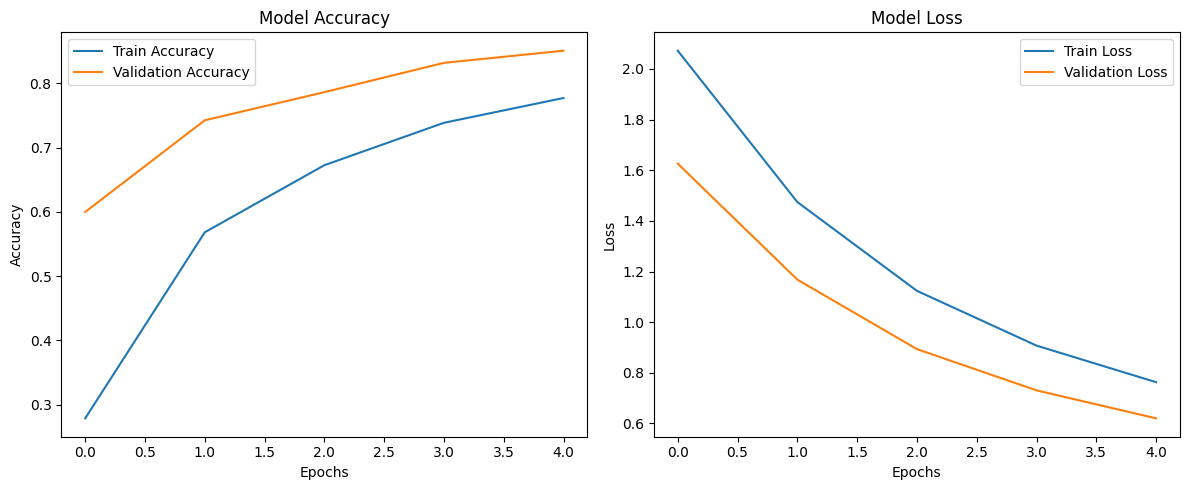

In [7]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 5))
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history)


In [8]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")


Test Accuracy: 0.85


313/313 [==============================] - 60s 190ms/step


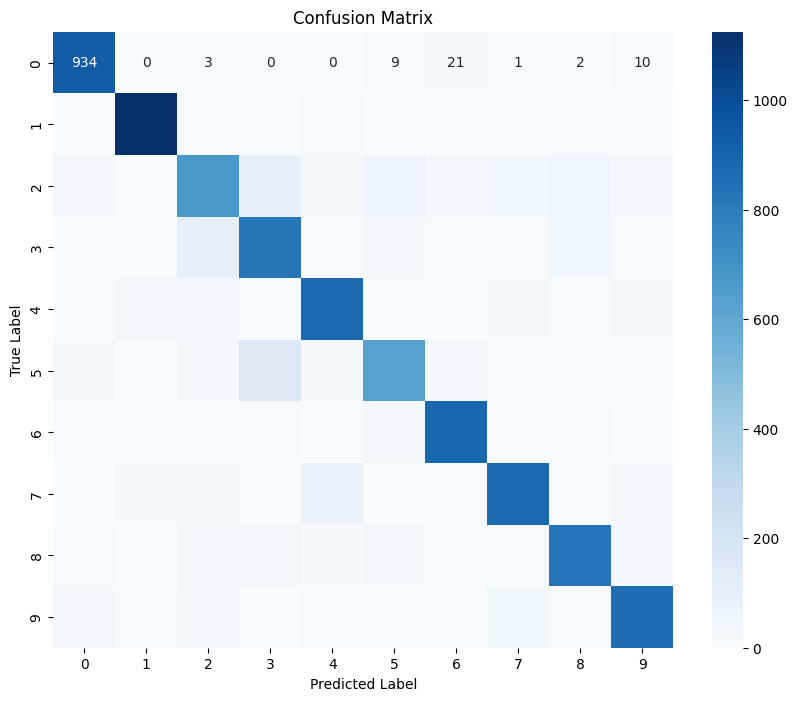

In [9]:
# Confusion matrix
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [10]:
# Classification report
print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       980
           1       0.94      0.99      0.96      1135
           2       0.74      0.65      0.69      1032
           3       0.74      0.81      0.78      1010
           4       0.87      0.89      0.88       982
           5       0.80      0.71      0.75       892
           6       0.89      0.92      0.90       958
           7       0.87      0.85      0.86      1028
           8       0.87      0.85      0.86       974
           9       0.87      0.85      0.86      1009

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



1/1 [==============================] - 0s 40ms/step


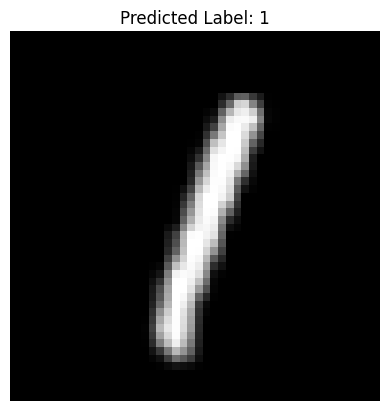

In [15]:
# Predict single image
def predict_single_image(img):
    img_resized = resize(np.expand_dims(img, axis=0), (48, 48))
    if img_resized.shape[-1] == 1:
        img_resized = np.repeat(img_resized, 3, axis=-1)
    img_resized = img_resized / 255.0
    prediction = model.predict(img_resized)
    predicted_class = np.argmax(prediction)
    return predicted_class

sample_image = x_test[5]
predicted_label = predict_single_image(sample_image)
plt.imshow(sample_image[:, :, 0], cmap='gray')
plt.title(f"Predicted Label: {predicted_label}")
plt.axis('off')
plt.show()

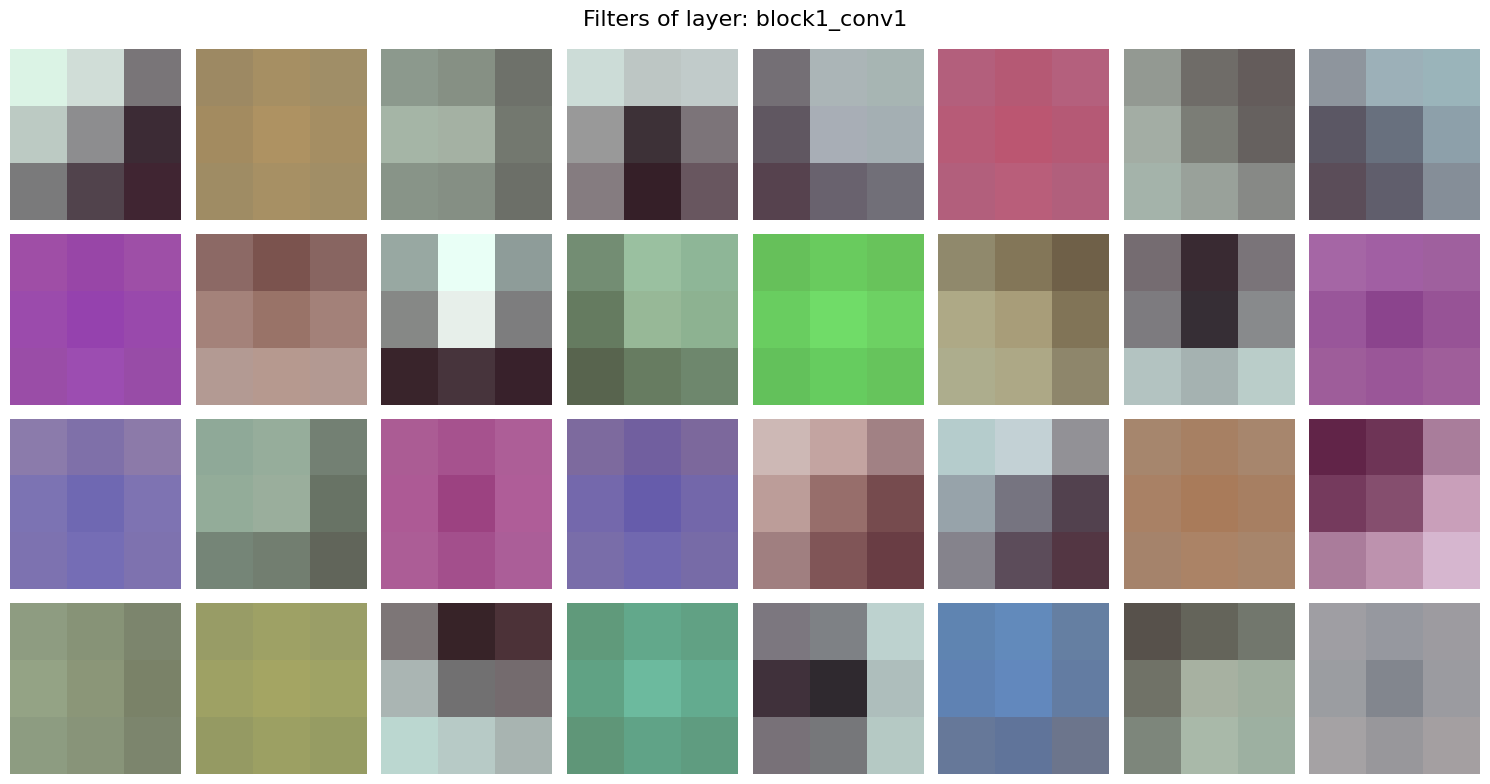

In [12]:
# Function to visualize filters of a convolutional layer
def visualize_filters(layer_name, model):
    layer = model.get_layer(layer_name)
    weights, biases = layer.get_weights()
    num_filters = weights.shape[-1]

    # Normalize the filter weights
    weights = (weights - weights.min()) / (weights.max() - weights.min())

    # Visualize each filter
    plt.figure(figsize=(15, 8))
    for i in range(min(num_filters, 32)):  # Limit visualization to 32 filters
        plt.subplot(4, 8, i + 1)
        plt.imshow(weights[:, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f"Filters of layer: {layer_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize filters of the first convolutional layer in VGG16
visualize_filters('block1_conv1', vgg_base)


Epoch 1/5
20/20 [==============================] - 80s 4s/step - loss: 3.9615 - accuracy: 0.2542 - val_loss: 3.1148 - val_accuracy: 0.6317
Epoch 2/5
20/20 [==============================] - 78s 4s/step - loss: 2.7309 - accuracy: 0.5386 - val_loss: 2.2289 - val_accuracy: 0.7563
Epoch 3/5
20/20 [==============================] - 76s 4s/step - loss: 2.0579 - accuracy: 0.6574 - val_loss: 1.7308 - val_accuracy: 0.7872
Epoch 4/5
20/20 [==============================] - 77s 4s/step - loss: 1.6694 - accuracy: 0.7218 - val_loss: 1.4591 - val_accuracy: 0.8103
Epoch 5/5
20/20 [==============================] - 73s 4s/step - loss: 1.4604 - accuracy: 0.7598 - val_loss: 1.3005 - val_accuracy: 0.8325


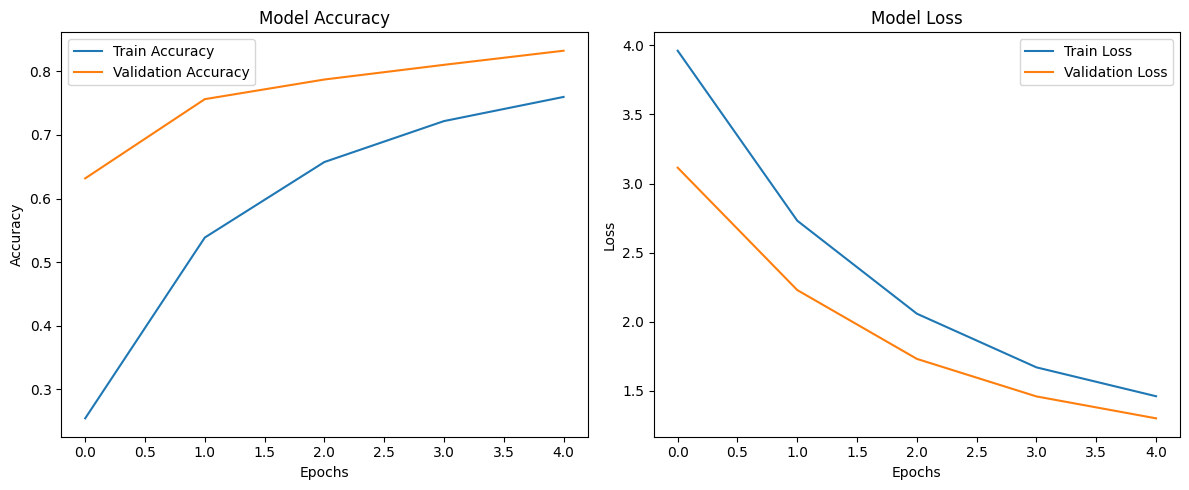

Test Accuracy with Regularization: 0.83


In [13]:
from tensorflow.keras.regularizers import l2

# Rebuild the model with regularization
model = Sequential([
    vgg_base,
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
    Dropout(0.5),  # Dropout
    Dense(10, activation='softmax', kernel_regularizer=l2(0.01))  # L2 regularization
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune on a reduced dataset for quicker results
subset_size = 5000
x_train_subset = x_train[:subset_size]
y_train_subset = y_train[:subset_size]

# Train the model
history = model.fit(x_train_subset, y_train_subset, epochs=5, batch_size=256, validation_data=(x_test, y_test))

# Plot training history
plot_history(history)

# Evaluate the model after adding regularization
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy with Regularization: {test_accuracy:.2f}")
